# Quantum Neural Network

This is an experiment that creates a neural network inspired by the path integral formulation of quantum mechanics. In ordinary NNs, color or grayscale channels are coded by numbers, which are numbers between 0 and 1. But, probabilities are also coded by numbers between 0 and 1, so there is a natural bias toward dark or light pixels. Moreover, each pixel in a sense represents a probability weight as both color/value are coded with the same field. These problems can be overcome with training, but the hypotheses is that this takes computing power and there may be a better way. 

In this NN, color or grayscale channels are translated into complex phases with magnitude 1. Thus, all colors/values have the same weight to start. Weights in the transition matrices are also encoded as complex phases with magnitude of 1. Thus, the probability weights that emerge can only emerge through correlations of neighboring pixels, not from pixels inherent weight itself.

Consider a grayscale image with 4 pixels. We first normalize the pixel values to take values between $0$ and $\pi$ denoted $\theta_n$. The pixel value is then translated into a complex phase $\theta_n \rightarrow e^{i\theta_n}$. All pixels have the same weight since the norm is 1 and the value is encoded in the phase. 

$$
\begin{bmatrix} e^{i\theta_1} \\ e^{i\theta_2} \\ e^{i\theta_3} \\ e^{i\theta_4} \end{bmatrix} \longrightarrow 
\begin{bmatrix} z_1 \\ z_2 \\ z_3 \\ z_4 \end{bmatrix} =
\begin{bmatrix} 
e^{i\phi_{11}} & e^{i\phi_{12}} & e^{i\phi_{13}} & e^{i\phi_{14}} \\
e^{i\phi_{21}} & e^{i\phi_{22}} & e^{i\phi_{23}} & e^{i\phi_{24}} \\
e^{i\phi_{31}} & e^{i\phi_{32}} & e^{i\phi_{33}} & e^{i\phi_{34}} \\
e^{i\phi_{41}} & e^{i\phi_{42}} & e^{i\phi_{43}} & e^{i\phi_{44}} 
\end{bmatrix}
\begin{bmatrix} e^{i\theta_1} \\ e^{i\theta_2} \\ e^{i\theta_3} \\ e^{i\theta_4} \end{bmatrix}
$$

In general, the magnitudes $|z_n|$ will no longer be equal to $1$ since the phases of neighboring pixels can add up constructively or destructively. 

Following the linear operation, the magnitudes (but not the phases) are subjected to an activation function. Note that ReLU will not work here as the magnitudes are all positive. Sigmoid is a more appropriate choice here, and we employ it here. However, more complex activation functions that utilize the phase information may be effective. The activation step is represented by
$$
z_n = |z_n| e^{i \theta_n} \longrightarrow z'_n = f(|z_n|) e^{i \theta_n}
$$

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import math

### Import and Process Images
Importing the FashionMNIST data. Applying the sigmoid transformation at the end so that all values are between zero and one.

In [2]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

valid_transforms = transforms.Compose([
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Create training set (with no transformations)
raw_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=None)

# Split the training data into pure training data and validation data (80/20 split)
train_size = int(len(raw_data) * 0.6) # 60% training data
valid_size = int(len(raw_data) * 0.2) # 20% validation data
test_size = len(raw_data)-(train_size+valid_size)

training_data, validation_data, testing_data = torch.utils.data.random_split(raw_data, [train_size, valid_size, test_size])

# Apply the respective transformations to each dataset
training_data.dataset.transform = train_transforms
validation_data.dataset.transform = valid_transforms
testing_data.dataset.transform = test_transforms

# Create test set and define test dataloader
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=32)
test_loader = DataLoader(testing_data, batch_size=32)

### Visualizing the Data

1


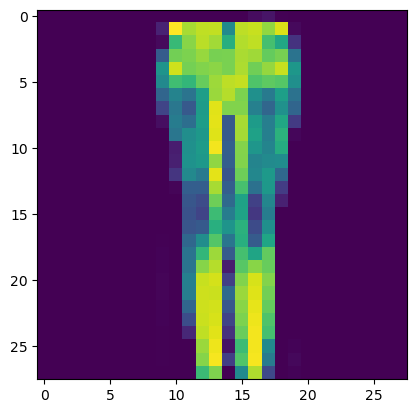

6


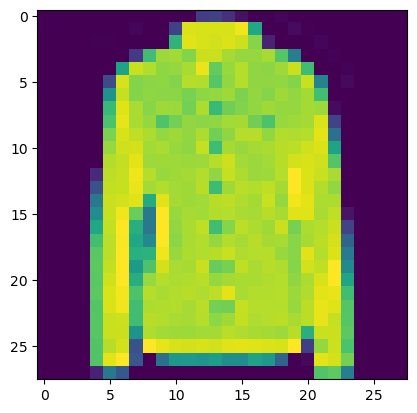

2


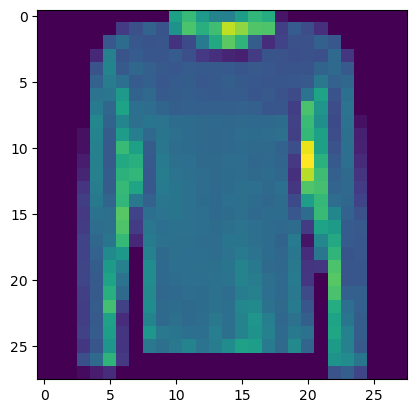

6


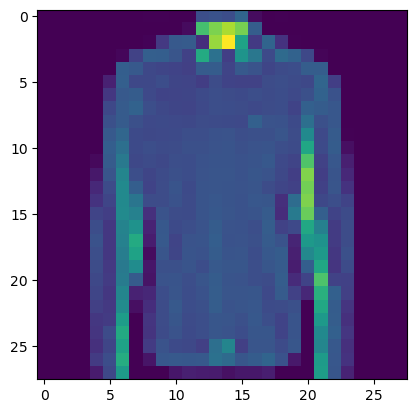

2


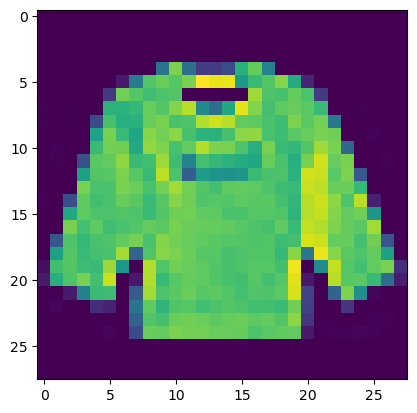

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()
        
# Explore data
show5(test_loader)

### Custom Activation Functions

#### Scaled Log
Similar to the Symmetric Log, this log can be scaled but is still linear at the origin (with slope 1). We only need it for positive values so we don't need the negative half of the Slog function.

In [4]:
class Slog(nn.Module): 
    def __init__(self, a=1): 
        super(Slog, self).__init__()
        self.a = a
          
    def forward(self, x): 
        return self.a*torch.log(x/self.a+1)

In [45]:
# F.dropout is not implemented for complex numbers yet, so here's a workaround  
class dropout_complex(nn.Module): 
    def __init__(self, p=.2): 
        super(dropout_complex, self).__init__()
        self.p = p
          
    def forward(self, x): 
        if x.is_complex():
            mask = torch.nn.functional.dropout(torch.ones_like(x.real), p=self.p)
            return x * mask
        else:
            return torch.nn.functional.dropout(x, p=self.p)

In [53]:
class Net(nn.Module):
    def __init__(self, features=[256, 128], drop_rate=0, momentum=0, learning_rate=.01, weight_decay=0, bias=False):
        """
        The Neural Network class. 
        Note: the optimizer and criterion are specified in this class itself
        ...

        Attributes
        ----------
        features : list of integers, optional, default=[256, 128]
            sets the number of features in the two hidden layers
        drop_rate : float, optional, default=.2
            sets the dropout rate
        momentum : float, optional, default=.9
            sets the momentum coefficient of the optimizer
        learning_rate : float, optional, default=.001
            sets the learning rate of the optimizer

        Methods
        -------
        train_it(epochs=10)
            trains the network, prints loss and accuracy, and returns training and validation loss history as lists
            
        test_it()
            tests the network on the test set and prints loss and accuracy
        """
        
        # Initialize base class
        super().__init__()
        
        #Define parameters
        self.bias = bias
        self.features = features
        self.activation = nn.Tanh()
        
        self.drop1 = dropout_complex(p=drop_rate)
        self.Thetas1 = nn.Linear(28*28, features[0], bias=bias)
        torch.nn.init.uniform_(self.Thetas1.weight, a=0, b=2*torch.pi)
        if bias:
            torch.nn.init.uniform_(self.Thetas1.bias, a=0, b=2*torch.pi)
        
        self.drop2 = dropout_complex(p=drop_rate)
        self.Thetas2 = nn.Linear(features[0], features[1], bias=bias)
        torch.nn.init.uniform_(self.Thetas2.weight, a=0, b=2*torch.pi)
        if bias:
            torch.nn.init.uniform_(self.Thetas2.bias, a=0, b=2*torch.pi)
        
        
        self.Thetas3 = nn.Linear(features[1], 10, bias=bias)
        torch.nn.init.uniform_(self.Thetas3.weight, a=0, b=2*torch.pi)
        if bias:
             torch.nn.init.uniform_(self.Thetas3.bias, a=0, b=2*torch.pi)
        
        self.output = nn.LogSoftmax(dim=1)
        
        
        # Define optimizer and criterion
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        self.criterion = nn.NLLLoss()
    
        
    def forward(self, x):
        bias = self.bias
        x = torch.flatten(x,1)
        x = torch.complex(torch.cos(torch.pi*x), torch.sin(torch.pi*x))
        
        Phases1 = torch.complex(torch.cos(self.Thetas1.weight), torch.sin(self.Thetas1.weight))
        x = F.linear(x, Phases1)
        if bias:
            Biases1 = torch.complex(torch.cos(self.Thetas1.bias), torch.sin(self.Thetas1.bias))
            x = x + Biases1
        x = self.activation(x.abs())/x.abs()*x
        x = self.drop1(x)
        
        Phases2 = torch.complex(torch.cos(self.Thetas2.weight), torch.sin(self.Thetas2.weight))
        x = F.linear(x, Phases2)
        if bias:
            Biases2 = torch.complex(torch.cos(self.Thetas2.bias), torch.sin(self.Thetas2.bias))
            x = x + Biases2
        x = self.activation(x.abs())/x.abs()*x
        x = self.drop2(x)
        
        Phases3 = torch.complex(torch.cos(self.Thetas3.weight), torch.sin(self.Thetas3.weight))
        x = F.linear(x, Phases3)
        if bias:
            Biases3 = torch.complex(torch.cos(self.Thetas3.bias), torch.sin(self.Thetas3.bias))
            x = x + Biases3
        x = self.output(x.abs())

        return x
    
    def train_it(self, epochs=10):
        """Trains the network

        Parameters
        ----------
        epochs : str, optional
            Number of epochs in the training run (default is 10)
        """
            
        # First choose the device to do computations on
        device = 'cpu'
        
        # Note: complex numbers are not working on mps. Fixing device to be cpu woth complex numbers
#         if torch.backends.mps.is_available():
#             device = 'mps' # Use MPS (Metal Performance Shader) on Macs
#         elif torch.cuda.is_available():
#             device = 'cuda' # Use Cuda everywhere else when GPU is available
        
        self = self.to(device)
        
        # Initialize data outputs
        train_loss_history = list()
        val_loss_history = list()
        train_accuracy_history = list()
        val_accuracy_history = list()

        for epoch in range(epochs):
            # Training 
            self.train()
            train_loss = 0.0
            train_accuracy = 0.0
            n = 0
            t0 = time.time()

            for inputs, labels in iter(train_loader):
                n += 1
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()

                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_loss = (train_loss*(n-1) + loss.item())/n

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = (top_class == labels.view(*top_class.shape))
                train_accuracy = (train_accuracy*(n-1) +100*torch.mean(equals.type(torch.FloatTensor)).item())/n

            # Validating
            self.eval()
            val_loss = 0.0
            val_accuracy = 0.0
            n = 0

            for inputs, labels in iter(valid_loader):
                n += 1
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()

                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)

                val_loss = (val_loss*(n-1) + loss.item())/n

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = (top_class == labels.view(*top_class.shape))
                val_accuracy = (val_accuracy*(n-1) +100*torch.mean(equals.type(torch.FloatTensor)).item())/n

            train_loss_history.append(train_loss)
            train_accuracy_history.append(train_accuracy)

            val_loss_history.append(val_loss)
            val_accuracy_history.append(val_accuracy)

            print("===============================")
            print("Epoch {}/{} completed in {} seconds on {}".format(epoch+1, epochs, time.time()-t0, device))
            print("Training Loss = {}".format(train_loss))
            print("Validation Loss = {}".format(val_loss))
            print("Training Accuracy = {}%".format(train_accuracy))
            print("Validation Accuracy = {}%".format(val_accuracy))
             
 
        return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history
    
    def test_it(self):
        """Runs a quick test on the Testing Set and prints loss and accuracy"""
        # First choose the device to do computations on
        device = 'cpu'
#         if torch.backends.mps.is_available():
#             device = 'mps' # Use MPS (Metal Performance Shader) on Macs
#         elif torch.cuda.is_available():
#             device = 'cuda' # Use Cuda everywhere else when GPU is available
        
        self = self.to(device)
        self.eval()
        test_loss = 0.0
        test_accuracy = 0.0
        n = 0

        for inputs, labels in iter(test_loader):
            n += 1
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()

            outputs = self.forward(inputs)
            loss = self.criterion(outputs, labels)

            test_loss = (test_loss*(n-1) + loss.item())/n

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = (top_class == labels.view(*top_class.shape))
            test_accuracy = (test_accuracy*(n-1) +100*torch.mean(equals.type(torch.FloatTensor)).item())/n

        print("===============================")
        print("Test Loss = {}".format(test_loss))
        print("Test Accuracy = {}%".format(test_accuracy))
        print("===============================")


Epoch 1/50 completed in 7.754846096038818 seconds on cpu
Training Loss = 2.1356043959988487
Validation Loss = 1.4536216456095383
Training Accuracy = 67.23055555555564%
Validation Accuracy = 72.31666666666669%
Epoch 2/50 completed in 7.717099666595459 seconds on cpu
Training Loss = 1.1817059729430412
Validation Loss = 0.9169928096930183
Training Accuracy = 75.10555555555565%
Validation Accuracy = 76.97500000000002%
Epoch 3/50 completed in 7.745651960372925 seconds on cpu
Training Loss = 0.8188174147870809
Validation Loss = 0.7408342972993853
Training Accuracy = 78.18333333333334%
Validation Accuracy = 79.44999999999993%
Epoch 4/50 completed in 7.779958009719849 seconds on cpu
Training Loss = 0.6691007390287182
Validation Loss = 0.6495202987591425
Training Accuracy = 79.79722222222235%
Validation Accuracy = 80.19999999999997%
Epoch 5/50 completed in 7.730560064315796 seconds on cpu
Training Loss = 0.5898665650619409
Validation Loss = 0.6011579734086995
Training Accuracy = 81.280555555555

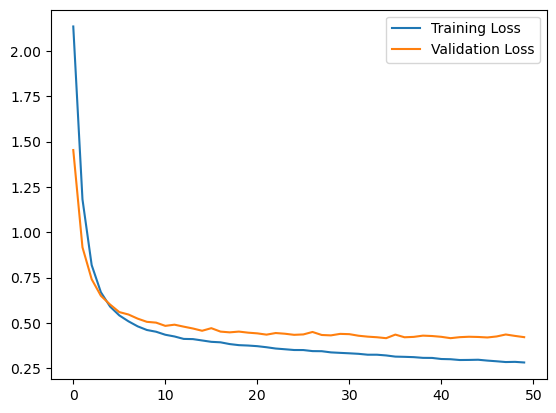

In [54]:
net = Net(features=[256,128], drop_rate=.2, learning_rate=.1, momentum=.8, bias=False)
train_loss_history, val_loss_history, train_acc_history, val_acc_history = net.train_it(epochs=50)

plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [55]:
net.test_it()

Test Loss = 0.4504323871533076
Test Accuracy = 85.55000000000011%


In [19]:
print(net.Thetas1.weight.mean())
print(net.Thetas2.weight.mean())
print(net.Thetas3.weight.mean())

print(net.Thetas1.bias.mean())
print(net.Thetas2.bias.mean())
print(net.Thetas1.bias.mean())

tensor(3.1386, grad_fn=<MeanBackward0>)
tensor(3.1376, grad_fn=<MeanBackward0>)
tensor(3.0943, grad_fn=<MeanBackward0>)
tensor(3.1325, grad_fn=<MeanBackward0>)
tensor(3.0807, grad_fn=<MeanBackward0>)
tensor(3.1325, grad_fn=<MeanBackward0>)


In [ ]:
print(net)

In [ ]:
M = nn.Linear(4, 3, bias=False)
print(M.weight)
torch.nn.init.normal_(M.weight, 
                      mean=0, std=.1) 
  
# Displaying the initialized weights 
print(M.weight)


C = nn.Linear(4,3, bias=False, dtype=torch.cfloat)
print(C.weight)

with torch.no_grad():
    C.weight = nn.Parameter(C.weight/torch.abs(C.weight))
print(C.weight)

Thetas = nn.Linear(4, 3, bias=False)
torch.nn.init.normal_(Thetas.weight, 
                      mean=0, std=.1)

Phases = nn.Linear(4,3, bias=False, dtype=torch.cfloat)
Phases.weight = nn.Parameter(torch.complex(torch.cos(Thetas.weight), torch.sin(Thetas.weight)))
    
print(Phases.weight)
print(torch.abs(Phases.weight))
